## 4. Isolation Forest (iForest)

In [ ]:
!pip install pyod
!pip install combo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=f154593de033ae7dcf835f7e2ba25f4f8ea95583513a8e96440f59f5c5d613a2
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=f38cfe9aa54a8a5b30590c90a4031d1872ec05d9d9095dda994bfc003b38ee75
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
X_train_pd.head()

,0,1,2,3,4,5
0,2.603910,2.907389,2.926608,3.011738,3.046527,2.549003
1,3.368960,3.253818,3.101950,2.619852,3.032668,3.141084
2,3.175317,2.868588,2.971171,3.296546,2.497034,2.880892
3,2.893902,2.834827,2.659174,2.829891,3.250861,3.321339
4,3.170353,3.224404,3.170562,2.945232,3.422810,3.405451


In [ ]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold,
                 'Normal', 'Outlier')
    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    # The count and count %
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    # The average
    stat = df.groupby('Group').mean().round(2).reset_index()
    # Put the count and the average together
    stat = cnt.merge(stat, left_on='Group', right_on='Group')
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

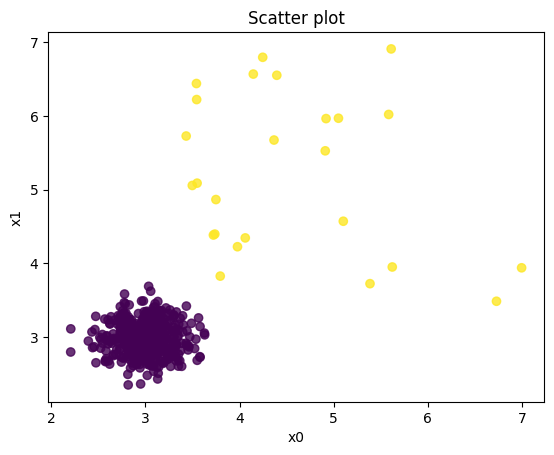

In [ ]:
plot_data()

### Step 1: Build the model

In [ ]:
from pyod.models.iforest import IForest
isft = IForest(contamination=0.05, max_samples=40, behaviour='new')
isft.fit(X_train)

# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: -5.687290915989962e-15
The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}


In [ ]:
isft.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 40,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

In [ ]:
isft_vi = isft.feature_importances_
isft_vi

array([0.14499174, 0.16833625, 0.15133928, 0.17206395, 0.18132347,
       0.1819453 ])

<Axes: >

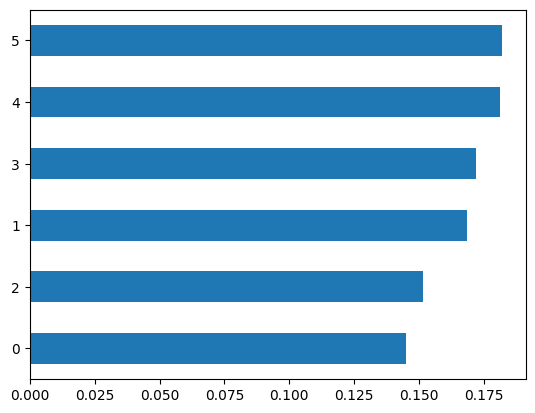

In [ ]:
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':X_train_pd.columns, 'y_axis':isft_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

### Step 2: Determine the threshold

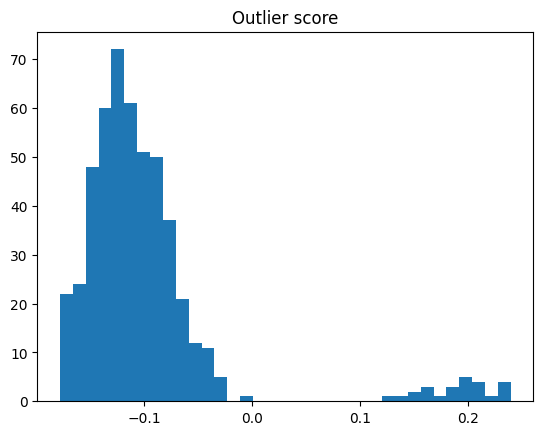

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Step 3: Descriptive statistics

In [ ]:
threshold = isft.threshold_ # Or other value from the above histogram
feature_list = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6']
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,-0.11
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,0.19


In [ ]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,2.98,2.99,2.99,3.01,2.99,3.00,-0.11
1,Outlier,25,5.0,5.00,5.54,5.23,5.05,5.06,4.88,0.19


In [ ]:
confusion_matrix_threshold(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Step 4: Averages

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

# Test a range of maximum samples
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k)
    isft = IForest(contamination=0.05, n_estimators=k)
    isft.fit(X_train)

    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train)
    test_scores[:, i] = isft.decision_function(X_test)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

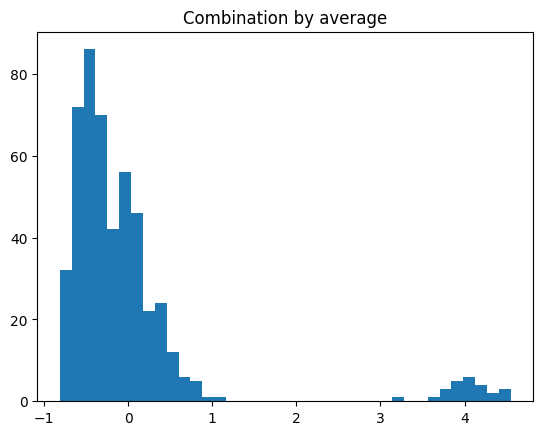

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [ ]:
descriptive_stat_threshold(X_train,y_train_by_average, 1.5)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,-0.21
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,4.05


In [ ]:
descriptive_stat_threshold(X_test,y_test_by_average, 1.5)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,2.98,2.99,2.99,3.01,2.99,3.00,-0.19
1,Outlier,25,5.0,5.00,5.54,5.23,5.05,5.06,4.88,4.12
